# [Sentence-BERT](https://arxiv.org/pdf/1908.10084.pdf)

[Reference Code](https://www.pinecone.io/learn/series/nlp/train-sentence-transformers-softmax/)

In [27]:
import os
import math
import re
from   random import *
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Set GPU device
device = torch.device("mps")
device
print(device)

mps


## 1. Data

### Train, Test, Validation 

In [28]:
import datasets
snli = datasets.load_dataset('snli')
mnli = datasets.load_dataset('glue', 'mnli')
mnli['train'].features, snli['train'].features

({'premise': Value(dtype='string', id=None),
  'hypothesis': Value(dtype='string', id=None),
  'label': ClassLabel(names=['entailment', 'neutral', 'contradiction'], id=None),
  'idx': Value(dtype='int32', id=None)},
 {'premise': Value(dtype='string', id=None),
  'hypothesis': Value(dtype='string', id=None),
  'label': ClassLabel(names=['entailment', 'neutral', 'contradiction'], id=None)})

In [29]:
# List of datasets to remove 'idx' column from
mnli.column_names.keys()

dict_keys(['train', 'validation_matched', 'validation_mismatched', 'test_matched', 'test_mismatched'])

In [30]:
# Remove 'idx' column from each dataset
for column_names in mnli.column_names.keys():
    mnli[column_names] = mnli[column_names].remove_columns('idx')

In [31]:
mnli.column_names.keys()

dict_keys(['train', 'validation_matched', 'validation_mismatched', 'test_matched', 'test_mismatched'])

In [32]:
import numpy as np
np.unique(mnli['train']['label']), np.unique(snli['train']['label'])
#snli also have -1

(array([0, 1, 2]), array([-1,  0,  1,  2]))

In [33]:
# there are -1 values in the label feature, these are where no class could be decided so we remove
snli = snli.filter(
    lambda x: 0 if x['label'] == -1 else 1
)

In [34]:
import numpy as np
np.unique(mnli['train']['label']), np.unique(snli['train']['label'])
#snli also have -1

(array([0, 1, 2]), array([0, 1, 2]))

In [35]:
# Assuming you have your two DatasetDict objects named snli and mnli
from datasets import DatasetDict
# Merge the two DatasetDict objects

# todo increase range fot better results
raw_dataset = DatasetDict({
    'train': datasets.concatenate_datasets([snli['train'], mnli['train']]).shuffle(seed=55).select(list(range(10))),
    'test': datasets.concatenate_datasets([snli['test'], mnli['test_mismatched']]).shuffle(seed=55).select(list(range(10))),
    'validation': datasets.concatenate_datasets([snli['validation'], mnli['validation_mismatched']]).shuffle(seed=55).select(list(range(10)))
})
#remove .select(list(range(1000))) in order to use full dataset
# Now, merged_dataset_dict contains the combined datasets from snli and mnli
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 10
    })
    test: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 10
    })
    validation: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 10
    })
})

## 2. Preprocessing

In [36]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [37]:
def preprocess_function(examples):
    max_seq_length = 128
    padding = 'max_length'
    # Tokenize the premise
    premise_result = tokenizer(
        examples['premise'], padding=padding, max_length=max_seq_length, truncation=True)
    #num_rows, max_seq_length
    # Tokenize the hypothesis
    hypothesis_result = tokenizer(
        examples['hypothesis'], padding=padding, max_length=max_seq_length, truncation=True)
    #num_rows, max_seq_length
    # Extract labels
    labels = examples["label"]
    #num_rows
    return {
        "premise_input_ids": premise_result["input_ids"],
        "premise_attention_mask": premise_result["attention_mask"],
        "hypothesis_input_ids": hypothesis_result["input_ids"],
        "hypothesis_attention_mask": hypothesis_result["attention_mask"],
        "labels" : labels
    }

tokenized_datasets = raw_dataset.map(
    preprocess_function,
    batched=True,
)

tokenized_datasets = tokenized_datasets.remove_columns(['premise','hypothesis','label'])
tokenized_datasets.set_format("torch")

In [38]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['premise_input_ids', 'premise_attention_mask', 'hypothesis_input_ids', 'hypothesis_attention_mask', 'labels'],
        num_rows: 10
    })
    test: Dataset({
        features: ['premise_input_ids', 'premise_attention_mask', 'hypothesis_input_ids', 'hypothesis_attention_mask', 'labels'],
        num_rows: 10
    })
    validation: Dataset({
        features: ['premise_input_ids', 'premise_attention_mask', 'hypothesis_input_ids', 'hypothesis_attention_mask', 'labels'],
        num_rows: 10
    })
})

## 3. Data loader

In [39]:
from torch.utils.data import DataLoader

# initialize the dataloader
batch_size = 32
train_dataloader = DataLoader(
    tokenized_datasets['train'], 
    batch_size=batch_size, 
    shuffle=True
)
eval_dataloader = DataLoader(
    tokenized_datasets['validation'], 
    batch_size=batch_size
)
test_dataloader = DataLoader(
    tokenized_datasets['test'], 
    batch_size=batch_size
)

In [40]:
for batch in train_dataloader:
    print(batch['premise_input_ids'].shape)
    print(batch['premise_attention_mask'].shape)
    print(batch['hypothesis_input_ids'].shape)
    print(batch['hypothesis_attention_mask'].shape)
    print(batch['labels'].shape)
    break

torch.Size([10, 128])
torch.Size([10, 128])
torch.Size([10, 128])
torch.Size([10, 128])
torch.Size([10])


## 4. Model

In [41]:
# start from a pretrained bert-base-uncased model
from transformers import BertTokenizer, BertModel
model = BertModel.from_pretrained('bert-base-uncased')
model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

### Pooling
SBERT adds a pooling operation to the output of BERT / RoBERTa to derive a fixed sized sentence embedding

In [42]:
# define mean pooling function
def mean_pool(token_embeds, attention_mask):
    # reshape attention_mask to cover 768-dimension embeddings
    in_mask = attention_mask.unsqueeze(-1).expand(
        token_embeds.size()
    ).float()
    # perform mean-pooling but exclude padding tokens (specified by in_mask)
    pool = torch.sum(token_embeds * in_mask, 1) / torch.clamp(
        in_mask.sum(1), min=1e-9
    )
    return pool

## 5. Loss Function

## Classification Objective Function 
We concatenate the sentence embeddings $u$ and $v$ with the element-wise difference  $\lvert u - v \rvert $ and multiply the result with the trainable weight  $ W_t ∈  \mathbb{R}^{3n \times k}  $:

$ o = \text{softmax}\left(W^T \cdot \left(u, v, \lvert u - v \rvert\right)\right) $

where $n$ is the dimension of the sentence embeddings and k the number of labels. We optimize cross-entropy loss. This structure is depicted in Figure 1.

## Regression Objective Function. 
The cosine similarity between the two sentence embeddings $u$ and $v$ is computed (Figure 2). We use means quared-error loss as the objective function.

(Manhatten / Euclidean distance, semantically  similar sentences can be found.)

<img src="./figures/sbert-architecture.png" >

In [43]:
def configurations(u,v):
    # build the |u-v| tensor
    uv = torch.sub(u, v)   # batch_size,hidden_dim
    uv_abs = torch.abs(uv) # batch_size,hidden_dim
    
    # concatenate u, v, |u-v|
    x = torch.cat([u, v, uv_abs], dim=-1) # batch_size, 3*hidden_dim
    return x

def cosine_similarity(u, v):
    dot_product = np.dot(u, v)
    norm_u = np.linalg.norm(u)
    norm_v = np.linalg.norm(v)
    similarity = dot_product / (norm_u * norm_v)
    return similarity

<img src="./figures/sbert-ablation.png" width="350" height="300">

In [44]:
classifier_head = torch.nn.Linear(768*3, 3).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
optimizer_classifier = torch.optim.Adam(classifier_head.parameters(), lr=2e-5)

criterion = nn.CrossEntropyLoss()

In [45]:
from transformers import get_linear_schedule_with_warmup

# and setup a warmup for the first ~10% steps
total_steps = int(len(raw_dataset) / batch_size)
warmup_steps = int(0.1 * total_steps)
scheduler = get_linear_schedule_with_warmup(
		optimizer, num_warmup_steps=warmup_steps,
  	num_training_steps=total_steps - warmup_steps
)

# then during the training loop we update the scheduler per step
scheduler.step()

scheduler_classifier = get_linear_schedule_with_warmup(
		optimizer_classifier, num_warmup_steps=warmup_steps,
  	num_training_steps=total_steps - warmup_steps
)

# then during the training loop we update the scheduler per step
scheduler_classifier.step()

/opt/anaconda3/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


## 6. Training

In [46]:
from tqdm.auto import tqdm

num_epoch = 5
# 1 epoch should be enough, increase if wanted
for epoch in range(num_epoch):
    model.train()  
    classifier_head.train()
    # initialize the dataloader loop with tqdm (tqdm == progress bar)
    for step, batch in enumerate(tqdm(train_dataloader, leave=True)):
        # zero all gradients on each new step
        optimizer.zero_grad()
        optimizer_classifier.zero_grad()
        
        # prepare batches and more all to the active device
        inputs_ids_a = batch['premise_input_ids'].to(device)
        inputs_ids_b = batch['hypothesis_input_ids'].to(device)
        attention_a = batch['premise_attention_mask'].to(device)
        attention_b = batch['hypothesis_attention_mask'].to(device)
        label = batch['labels'].to(device)
        
        # extract token embeddings from BERT at last_hidden_state
        u = model(inputs_ids_a, attention_mask=attention_a)  
        v = model(inputs_ids_b, attention_mask=attention_b)  

        u_last_hidden_state = u.last_hidden_state # all token embeddings A = batch_size, seq_len, hidden_dim
        v_last_hidden_state = v.last_hidden_state # all token embeddings B = batch_size, seq_len, hidden_dim

         # get the mean pooled vectors
        u_mean_pool = mean_pool(u_last_hidden_state, attention_a) # batch_size, hidden_dim
        v_mean_pool = mean_pool(v_last_hidden_state, attention_b) # batch_size, hidden_dim
        
        # build the |u-v| tensor
        uv = torch.sub(u_mean_pool, v_mean_pool)   # batch_size,hidden_dim
        uv_abs = torch.abs(uv) # batch_size,hidden_dim
        
        # concatenate u, v, |u-v|
        x = torch.cat([u_mean_pool, v_mean_pool, uv_abs], dim=-1) # batch_size, 3*hidden_dim
        
        # process concatenated tensor through classifier_head
        x = classifier_head(x) #batch_size, classifer
        
        # calculate the 'softmax-loss' between predicted and true label
        loss = criterion(x, label)
        
        # using loss, calculate gradients and then optimizerize
        loss.backward()
        optimizer.step()
        optimizer_classifier.step()

        scheduler.step() # update learning rate scheduler
        scheduler_classifier.step()
        
    print(f'Epoch: {epoch + 1} | loss = {loss.item():.6f}')

100%|██████████| 1/1 [00:03<00:00,  3.42s/it]


Epoch: 1 | loss = 1.152026


100%|██████████| 1/1 [02:37<00:00, 157.91s/it]


Epoch: 2 | loss = 1.140500


100%|██████████| 1/1 [05:09<00:00, 309.51s/it]


Epoch: 3 | loss = 1.143302


100%|██████████| 1/1 [03:05<00:00, 185.67s/it]


Epoch: 4 | loss = 1.152462


100%|██████████| 1/1 [02:33<00:00, 153.76s/it]


Epoch: 5 | loss = 1.141972


In [47]:
model.eval()
classifier_head.eval()
total_similarity = 0
predictions = []
true_labels = []
prediction_probabilities = []

with torch.no_grad():
    for step, batch in enumerate(eval_dataloader):
        # prepare batches and move all to the active device
        inputs_ids_a = batch['premise_input_ids'].to(device)
        inputs_ids_b = batch['hypothesis_input_ids'].to(device)
        attention_a = batch['premise_attention_mask'].to(device)
        attention_b = batch['hypothesis_attention_mask'].to(device)
        label = batch['labels'].to(device)
        
        # extract token embeddings from BERT at last_hidden_state
        u = model(inputs_ids_a, attention_mask=attention_a)[0]  # all token embeddings A = batch_size, seq_len, hidden_dim
        v = model(inputs_ids_b, attention_mask=attention_b)[0]  # all token embeddings B = batch_size, seq_len, hidden_dim

        # get the mean pooled vectors
        u_mean_pool = mean_pool(u, attention_a)  # (batch_size, hidden_dim)
        v_mean_pool = mean_pool(v, attention_b)  # (batch_size, hidden_dim)

        # Calculate cosine similarity 
        batch_similarity = torch.nn.functional.cosine_similarity(u_mean_pool, v_mean_pool, dim=-1)
        total_similarity += batch_similarity.sum().item()

        # Combine features for the classifier: [u, v, |u - v|]
        difference_uv = torch.abs(u_mean_pool - v_mean_pool)  # (batch_size, hidden_dim)
        classifier_input = torch.cat([u_mean_pool, v_mean_pool, difference_uv], dim=-1)  # (batch_size, 3*hidden_dim)

        # Pass from classifier head
        logits = classifier_head(classifier_input) 
        probabilities = torch.nn.functional.softmax(logits, dim=-1)

        # Determine the predicted class for each sample
        predicted_classes = torch.argmax(logits, dim=-1) 

        # Save predictions
        predictions.extend(predicted_classes.detach().cpu().tolist())
        true_labels.extend(label.detach().cpu().tolist())
        prediction_probabilities.extend(probabilities.detach().cpu().tolist())

# average cosine similarity
average_similarity = total_similarity / (len(eval_dataloader) * eval_dataloader.batch_size)
print(f"Average Cosine Similarity: {average_similarity:.4f}")

Average Cosine Similarity: 0.2409


/opt/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


               precision    recall  f1-score   support

   entailment       0.22      1.00      0.36         2
      neutral       0.00      0.00      0.00         5
contradiction       1.00      0.33      0.50         3

     accuracy                           0.30        10
    macro avg       0.41      0.44      0.29        10
 weighted avg       0.34      0.30      0.22        10



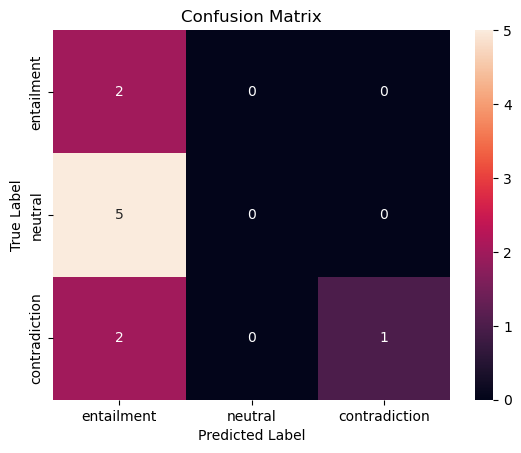

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

# classification report
class_names = ["entailment", "neutral", "contradiction"]
print(classification_report(true_labels, predictions, target_names=["entailment", "neutral", "contradiction"]))

# confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## 7. Inference

In [49]:
import torch
from sklearn.metrics.pairwise import cosine_similarity

def calculate_similarity(model, tokenizer, sentence_a, sentence_b, device):
    # Tokenize and convert sentences to input IDs and attention masks
    inputs_a = tokenizer(sentence_a, return_tensors='pt', truncation=True, padding=True).to(device)
    inputs_b = tokenizer(sentence_b, return_tensors='pt', truncation=True, padding=True).to(device)

    # Move input IDs and attention masks to the active device
    inputs_ids_a = inputs_a['input_ids']
    attention_a = inputs_a['attention_mask']
    inputs_ids_b = inputs_b['input_ids']
    attention_b = inputs_b['attention_mask']

    # Extract token embeddings from BERT
    u = model(inputs_ids_a, attention_mask=attention_a)[0]  # all token embeddings A = batch_size, seq_len, hidden_dim
    v = model(inputs_ids_b, attention_mask=attention_b)[0]  # all token embeddings B = batch_size, seq_len, hidden_dim

    # Get the mean-pooled vectors
    u = mean_pool(u, attention_a).detach().cpu().numpy().reshape(-1)  # batch_size, hidden_dim
    v = mean_pool(v, attention_b).detach().cpu().numpy().reshape(-1)  # batch_size, hidden_dim

    # Calculate cosine similarity
    similarity_score = cosine_similarity(u.reshape(1, -1), v.reshape(1, -1))[0, 0]

    return similarity_score

# Example usage:
sentence_a = 'Your contribution helped make it possible for us to provide our students with a quality education.'
sentence_b = "Your contributions were of no help with our students' education."
similarity = calculate_similarity(model, tokenizer, sentence_a, sentence_b, device)
print(f"Cosine Similarity: {similarity:.4f}")

Cosine Similarity: 0.8057


In [50]:
from sentence_transformers import SentenceTransformer
huggingface_model = SentenceTransformer('all-MiniLM-L6-v2')

In [51]:
def calculate_and_print_similarity(model, tokenizer, hf_model, sentence_a, sentence_b, device, pair_type):
    print(f"{pair_type} Pairs Cosine Similarity :")
    similarity = torch.tensor(calculate_similarity(model, tokenizer, sentence_a, sentence_b, device))
    hf_similarity = calculate_similarity_hf(hf_model, sentence_a, sentence_b)
    print(f"My Model: {similarity:.4f}")
    print(f"all-MiniLM-L6-v2 Model: {hf_similarity:.4f}")
    print()

def calculate_similarity_hf(model, sentence_a, sentence_b):
    embeddings = model.encode([sentence_a, sentence_b])
    return cosine_similarity([embeddings[0]], [embeddings[1]])[0, 0]

entailment_pair = ("A woman is jogging in the park", "A person is exercising outdoors")
neutral_pair = ("He is typing on his laptop.", "The library is a quiet place to work.")
contradiction_pair = ("The phone is fully charged.", "The battery is completely drained.")

calculate_and_print_similarity(model, tokenizer, huggingface_model, *entailment_pair, device, "Entailment")
calculate_and_print_similarity(model, tokenizer, huggingface_model, *neutral_pair, device, "Neutral")
calculate_and_print_similarity(model, tokenizer, huggingface_model, *contradiction_pair, device, "Contradiction")

Entailment Pairs Cosine Similarity :
My Model: 0.7128
all-MiniLM-L6-v2 Model: 0.4262

Neutral Pairs Cosine Similarity :
My Model: 0.6519
all-MiniLM-L6-v2 Model: 0.0947

Contradiction Pairs Cosine Similarity :
My Model: 0.8349
all-MiniLM-L6-v2 Model: 0.4858



In [52]:
# todo
torch.save(model.state_dict(), "sbert_model.pth")
torch.save(classifier_head.state_dict(), "classifier_head.pth")

print("Model saved to sbert_model.pth")

Model saved to sbert_model.pth
